# Table of Contents

1. [Imports & Global Constants](#Imports-&-Global-Constants)
<br>&emsp;- 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
<br>

2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset)
<br>&emsp;- 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
<br>

3. [Define Dataset Class](#Define-Dataset-Class)
<br>&emsp;- 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
<br>

4. [Check Data Sample](#Check-Data-Sample)
<br>&emsp;- 제공된 데이터가 어떤 모습인지 확인합니다.
<br>

5. [Setup Dataloader](#Setup-Dataloader)
<br>&emsp;- 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
<br>

6. [Define Functions for Training](#Define-Functions-for-Training)
<br>&emsp;- 학습을 도와주는 함수들을 정의합니다.
<br>

7. [Training](#Training)
<br>&emsp;- 학습을 진행합니다.
<br>

8. [Inference](#Inference)
<br>&emsp;- 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
<br>

9. [Result Visualization](#Result-Visualization)
<br>&emsp;- 인퍼런스 결과를 확인해봅니다.
<br>

10. [To CSV](#To-CSV)
<br>&emsp;- 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.optim.lr_scheduler as lr_scheduler
from scheduler import CosineAnnealingWarmUpRestarts
from adamp import AdamP
from HRnet_OCR import get_ocr_model
from loss import Calc_loss

# visualization
import matplotlib.pyplot as plt

import wandb
import random

In [2]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/train/DCM"
LABEL_ROOT = "../data/train/outputs_json"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [4]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [5]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [6]:
BATCH_SIZE = 4
LR = 2e-5

# default
#LR = 1e-4

RANDOM_SEED = 21

NUM_EPOCHS = 100    # CHANGE
VAL_EVERY = 1

SAVED_DIR = "/workspace/results_baseline/"

if not os.path.isdir(SAVED_DIR):                                                           
    os.mkdir(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [7]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [8]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [9]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [10]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [11]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [12]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [13]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # process a label of shape (H, W, NC)
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon to mask
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

# Check Data Sample

In [14]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [15]:
#tf = A.Resize(512, 512)
tf = A.Resize(1024, 1024)

#tf = A.Resize(2048, 2048)

In [16]:
train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)

In [17]:
image, label = train_dataset[0]

In [18]:
print(image.shape, label.shape)

torch.Size([3, 1024, 1024]) torch.Size([29, 1024, 1024])


In [19]:
len(train_dataset)

640

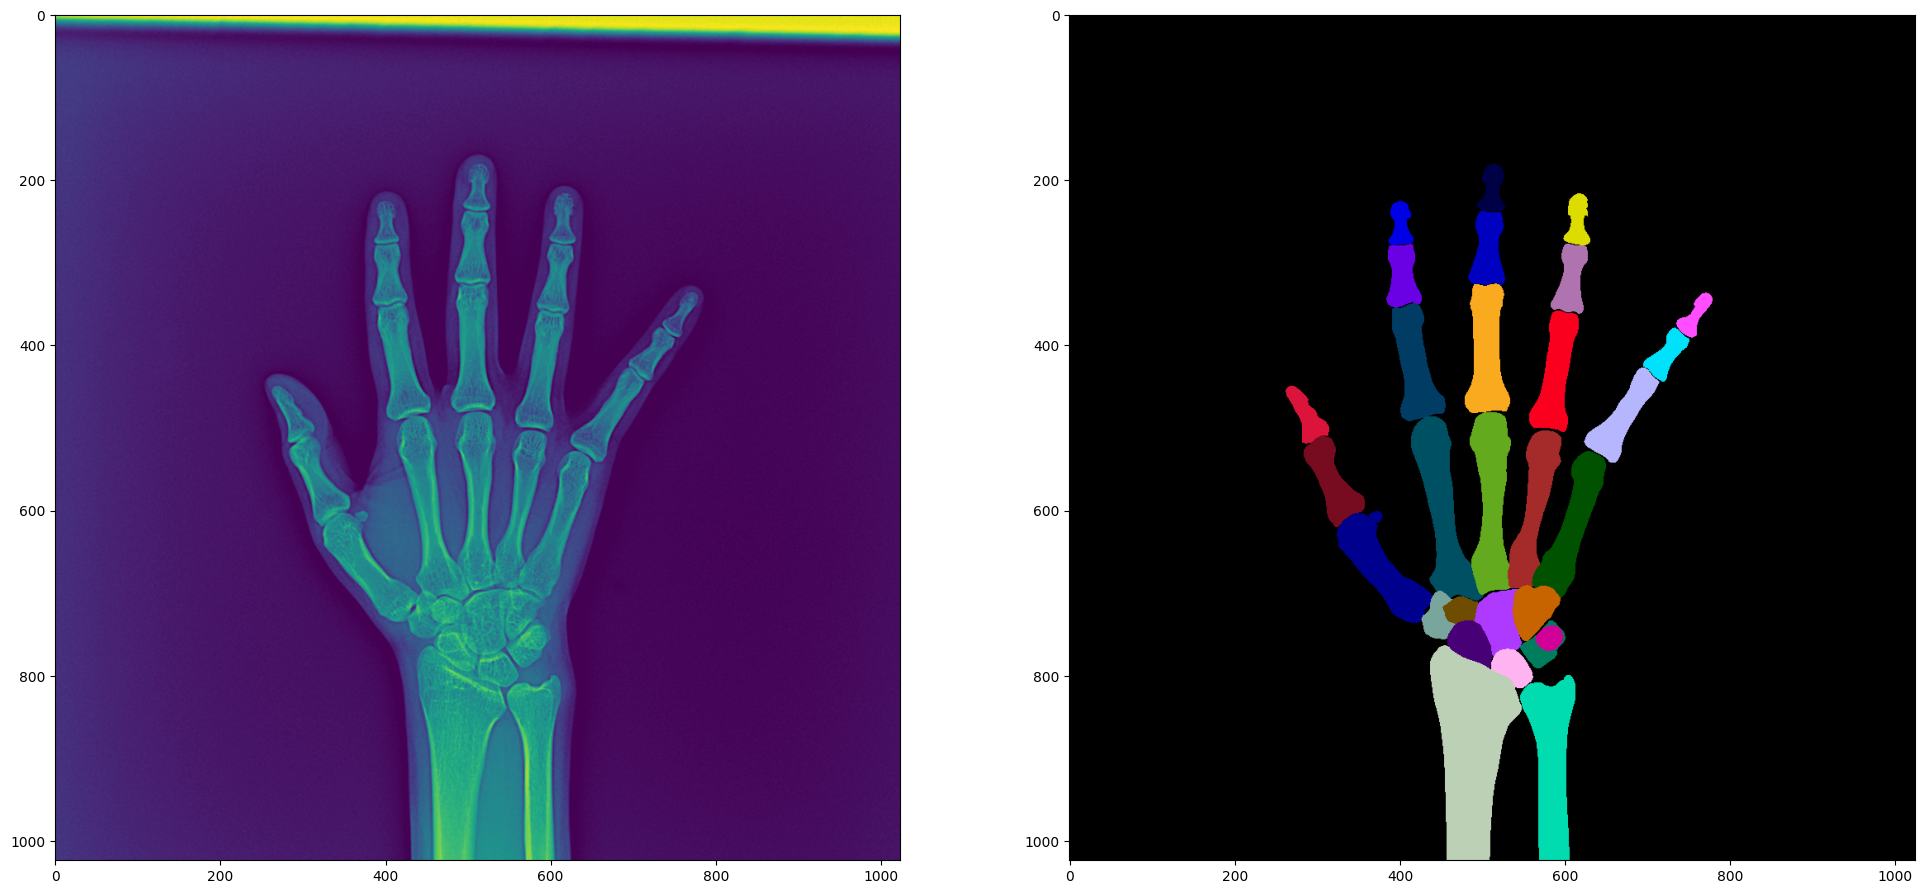

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # remove channel dimension
ax[1].imshow(label2rgb(label))

plt.show()

# Setup Dataloader

In [21]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    pin_memory=True,
)

# Define Functions for Training

In [22]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2) # (batch, class, h*w)
    y_pred_f = y_pred.flatten(2)

    multi_pred_true = y_true_f * y_pred_f # (batch, class, h*w)
    intersection = torch.sum(multi_pred_true, -1) # (batch, class) # h*w에 대해서 다 더함.
    eps = 0.0001

    # 참인데 맞추지 못한것.
    y_true_f = y_true_f.to(torch.int)
    b = (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

    k = y_true_f - multi_pred_true

    false_negative =  torch.sum((y_true_f - multi_pred_true),-1) /b
    # 거짓인데 맞춘것.
    false_positive = torch.sum(y_pred_f - multi_pred_true,-1) /b

    
    return (2. * intersection + eps) / b, false_negative, false_positive

In [23]:
import time
timestr = time.strftime("%m-%d-%H-%M")

saving_file_name = f'HRnet_OCR_1024_best_model_{timestr}.pt'
def save_model(model, file_name=saving_file_name):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)


In [24]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [25]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    set_seed()
    model.eval()

    dices = []
    fns = []
    fps = []
    with torch.no_grad():
        n_class = len(CLASSES)
        total_loss = 0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()         
            model = model.cuda()
            
            outputs = model(images)
            
            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)
            
            # restore original size
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()
            
            dice,fn,fp = dice_coef(outputs, masks)
            dices.append(dice)
            fns.append(fn)
            fps.append(fp)
        # dataloader batch 별로 틀린게 있는지 확인
    # print('dices per dataloader batch')
    # for i in range(len(dices)):
    #     valid_idx_tp = dices[i]
    #     valid_idx_fn = fns[i] 
    #     valid_idx_fp = fps[i]

    #     print('dataloader batch index : ',i)
    #     print(f'====> TP : {torch.mean(valid_idx_tp)} FN :{torch.mean(valid_idx_fn)} FP : {torch.mean(valid_idx_fp)}')
    #     print(f'{i}th batch: tp: {valid_idx_tp}')
    #     print(f'{i}th batch: fn: {valid_idx_fn}')
    #     print(f'{i}th batch: fp: {valid_idx_fp}')

                
    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(CLASSES, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)
    
    fns_per_class = torch.mean(torch.cat(fns, 0), 0)
    fps_per_class = torch.mean(torch.cat(fps, 0), 0)
    avg_dice = torch.mean(dices_per_class).item()
    avg_fns = torch.mean(fns_per_class).item()
    avg_fps = torch.mean(fps_per_class).item()
    
    wandb.log({"avg_dice": avg_dice, "avg_fns": avg_fns, "avg_fps": avg_fps})
    for i, c in enumerate(CLASSES):
        wandb.log({f"dice_{c}": dices_per_class[i].item()})
    return avg_dice
    

In [26]:
# def validation(epoch, model, data_loader, criterion, thr=0.5):
#     print(f'Start validation #{epoch:2d}')
#     model.eval()

#     dices = []
#     with torch.no_grad():
#         n_class = len(CLASSES)
#         total_loss = 0
#         cnt = 0

#         for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
#             images, masks = images.cuda(), masks.cuda()         
#             model = model.cuda()
            
#             outputs = model(images)
            
#             output_h, output_w = outputs.size(-2), outputs.size(-1)
#             mask_h, mask_w = masks.size(-2), masks.size(-1)
            
#             # # restore original size
#             # if output_h != mask_h or output_w != mask_w:
#             #     outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
                
#             # restore original size for hrnet_ocr
#             output_h, output_w = outputs.size(-2), outputs.size(-1)
#             mask_h, mask_w = masks.size(-2), masks.size(-1)
#             if output_h != mask_h or output_w != mask_w:
#                 outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
#             loss = criterion(outputs, masks)
#             total_loss += loss
#             cnt += 1
            
#             outputs = torch.sigmoid(outputs)
#             outputs = (outputs > thr).detach().cpu()
#             masks = masks.detach().cpu()
            
#             dice = dice_coef(outputs, masks)
#             dices.append(dice)
                
#     dices = torch.cat(dices, 0)
#     dices_per_class = torch.mean(dices, 0)
#     dice_str = [
#         f"{c:<12}: {d.item():.4f}"
#         for c, d in zip(CLASSES, dices_per_class)
#     ]
#     dice_str = "\n".join(dice_str)
#     print(dice_str)
    
#     avg_dice = torch.mean(dices_per_class).item()
    
#     return avg_dice

In [27]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Segmentation Model Experiment",
    entity="hi-ai",
    name=f'HRnet_OCR_1024',
    # track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "pretrained",
    "dataset": "hand_bone_image",
    "epochs": NUM_EPOCHS,
    "seed": RANDOM_SEED,
    "batch_size":BATCH_SIZE
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sdnmd98 (hi-ai). Use `wandb login --relogin` to force relogin


In [28]:
def train(model, data_loader, val_loader, criterion, optimizer):
    print(f'Start training..')
    set_seed()
    n_class = len(CLASSES)
    best_dice = 0.

    paitence = NUM_EPOCHS
    count=0
    
    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, (images, masks) in enumerate(data_loader):            
            # gpu 연산을 위해 device 할당
            images, masks = images.cuda(), masks.cuda()
            model = model.cuda()
            
            # inference
            outputs = model(images)
            
            # restore original size for hrnet_ocr
            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
            # loss 계산
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 10 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )
                #wandb.log({"Epoch": epoch+1,"Loss":round(loss.item(),4)}) # vallidation 계산할때마다 로스 계산.
                wandb.log({"learning_rate":optimizer.param_groups[0]['lr'],"Epoch": epoch+1,"Loss":round(loss.item(),4)}) # vallidation 계산할때마다 로스 계산.
                
                
        
        # lr update
        scheduler.step()
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)
            
            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)
                count=0
            else:
                count+=1
                print('this is not best dice! count :',count)
                if count >=paitence:
                    # 얼리스타핑 - 모델 학습 종료!
                    print('Early stopping!!!')
                    break

In [29]:
# def train(model, data_loader, val_loader, criterion, optimizer):
#     print(f'Start training..')
    
#     n_class = len(CLASSES)
#     best_dice = 0.
    
#     for epoch in range(NUM_EPOCHS):
#         model.train()

#         for step, (images, masks) in enumerate(data_loader):            
#             # gpu 연산을 위해 device 할당
#             images, masks = images.cuda(), masks.cuda()
#             model = model.cuda()
            
#             # inference
#             outputs = model(images)
            
#             # loss 계산
#             loss = criterion(outputs, masks)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             # step 주기에 따른 loss 출력
#             if (step + 1) % 25 == 0:
#                 print(
#                     f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
#                     f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
#                     f'Step [{step+1}/{len(train_loader)}], '
#                     f'Loss: {round(loss.item(),4)}'
#                 )
             
#         # validation 주기에 따른 loss 출력 및 best model 저장
#         if (epoch + 1) % VAL_EVERY == 0:
#             dice = validation(epoch + 1, model, val_loader, criterion)
            
#             if best_dice < dice:
#                 print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
#                 print(f"Save model in {SAVED_DIR}")
#                 best_dice = dice
#                 save_model(model)

# Training

In [30]:
# model = models.segmentation.fcn_resnet50(pretrained=True)

# # output class를 data set에 맞도록 수정
# model.classifier[4] = nn.Conv2d(512, len(CLASSES), kernel_size=1)

In [31]:
model = get_ocr_model(name='hrnet48',pretrained='/opt/ml/input/code/pretrained/hrnetv2_w48_imagenet_pretrained.pth')

# model = get_ocr_model(name='hrnet48')

{'ocr_distri_head.object_context_block.f_pixel.1.0.running_var', 'ocr_distri_head.object_context_block.f_object.1.0.bias', 'conv3x3_ocr.1.running_mean', 'aux_head.0.bias', 'ocr_distri_head.object_context_block.f_pixel.3.0.bias', 'conv3x3_ocr.1.weight', 'ocr_distri_head.object_context_block.f_pixel.1.0.bias', 'cls_head.weight', 'conv3x3_ocr.0.weight', 'ocr_distri_head.object_context_block.f_object.1.0.weight', 'conv3x3_ocr.1.running_var', 'ocr_distri_head.object_context_block.f_pixel.1.0.num_batches_tracked', 'aux_head.0.weight', 'ocr_distri_head.object_context_block.f_up.1.0.running_var', 'ocr_distri_head.conv_bn_dropout.1.0.running_var', 'ocr_distri_head.object_context_block.f_pixel.3.0.running_var', 'ocr_distri_head.object_context_block.f_up.0.weight', 'aux_head.1.weight', 'ocr_distri_head.conv_bn_dropout.1.0.num_batches_tracked', 'ocr_distri_head.object_context_block.f_down.1.0.bias', 'ocr_distri_head.conv_bn_dropout.1.0.bias', 'ocr_distri_head.object_context_block.f_object.1.0.runn

In [32]:
# Loss function 정의
# criterion = nn.BCEWithLogitsLoss()

criterion = Calc_loss()


# Optimizer 정의
# optimizer = optim.Adam(params=model.parameters(), lr=LR, weight_decay=1e-6)

optimizer = optim.AdamW(params=model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=30, eta_max=1e-2, T_up=10, gamma=0.7)

# unet++로 실험했을 때 초기 학습 속도, 수렴 속도가 너무 느림
#scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=5, T_mult=3, eta_max=3e-4,  T_up=3, gamma=0.4)

In [33]:
set_seed()

In [34]:
train(model, train_loader, valid_loader, criterion, optimizer)

Start training..
2023-06-19 18:24:31 | Epoch [1/100], Step [10/160], Loss: 0.8285
2023-06-19 18:24:49 | Epoch [1/100], Step [20/160], Loss: 0.8207
2023-06-19 18:25:08 | Epoch [1/100], Step [30/160], Loss: 0.8051
2023-06-19 18:25:26 | Epoch [1/100], Step [40/160], Loss: 0.7963
2023-06-19 18:25:45 | Epoch [1/100], Step [50/160], Loss: 0.7836
2023-06-19 18:26:03 | Epoch [1/100], Step [60/160], Loss: 0.7745
2023-06-19 18:26:22 | Epoch [1/100], Step [70/160], Loss: 0.7586
2023-06-19 18:26:40 | Epoch [1/100], Step [80/160], Loss: 0.7526
2023-06-19 18:26:59 | Epoch [1/100], Step [90/160], Loss: 0.7376
2023-06-19 18:27:17 | Epoch [1/100], Step [100/160], Loss: 0.7304
2023-06-19 18:27:36 | Epoch [1/100], Step [110/160], Loss: 0.7154
2023-06-19 18:27:54 | Epoch [1/100], Step [120/160], Loss: 0.7252
2023-06-19 18:28:13 | Epoch [1/100], Step [130/160], Loss: 0.7101
2023-06-19 18:28:31 | Epoch [1/100], Step [140/160], Loss: 0.7013
2023-06-19 18:28:50 | Epoch [1/100], Step [150/160], Loss: 0.6945
20


finger-1    : 0.1642
finger-2    : 0.4591
finger-3    : 0.4307
finger-4    : 0.2293
finger-5    : 0.2028
finger-6    : 0.0233
finger-7    : 0.3241
finger-8    : 0.2637
finger-9    : 0.2403
finger-10   : 0.3631
finger-11   : 0.3855
finger-12   : 0.2349
finger-13   : 0.1314
finger-14   : 0.0004
finger-15   : 0.1017
finger-16   : 0.1243
finger-17   : 0.2886
finger-18   : 0.0437
finger-19   : 0.2087
Trapezium   : 0.0043
Trapezoid   : 0.0000
Capitate    : 0.3148
Hamate      : 0.1487
Scaphoid    : 0.0008
Lunate      : 0.0073
Triquetrum  : 0.0104
Pisiform    : 0.0000
Radius      : 0.6009
Ulna        : 0.5480
Best performance at epoch: 1, 0.0000 -> 0.2019
Save model in /workspace/results_baseline/
2023-06-19 18:32:58 | Epoch [2/100], Step [10/160], Loss: 0.5473
2023-06-19 18:33:17 | Epoch [2/100], Step [20/160], Loss: 0.496
2023-06-19 18:33:35 | Epoch [2/100], Step [30/160], Loss: 0.4605
2023-06-19 18:33:54 | Epoch [2/100], Step [40/160], Loss: 0.4188
2023-06-19 18:34:12 | Epoch [2/100], Step


finger-1    : 0.0082
finger-2    : 0.0227
finger-3    : 0.0153
finger-4    : 0.0188
finger-5    : 0.5005
finger-6    : 0.0351
finger-7    : 0.1032
finger-8    : 0.1399
finger-9    : 0.3756
finger-10   : 0.1522
finger-11   : 0.1000
finger-12   : 0.3549
finger-13   : 0.2446
finger-14   : 0.0092
finger-15   : 0.0501
finger-16   : 0.0729
finger-17   : 0.0307
finger-18   : 0.0113
finger-19   : 0.1214
Trapezium   : 0.0097
Trapezoid   : 0.0448
Capitate    : 0.1449
Hamate      : 0.3164
Scaphoid    : 0.0611
Lunate      : 0.1922
Triquetrum  : 0.2275
Pisiform    : 0.0130
Radius      : 0.0903
Ulna        : 0.2712
this is not best dice! count : 1
2023-06-19 18:41:24 | Epoch [3/100], Step [10/160], Loss: 0.0667
2023-06-19 18:41:42 | Epoch [3/100], Step [20/160], Loss: 0.0699
2023-06-19 18:42:01 | Epoch [3/100], Step [30/160], Loss: 0.0687
2023-06-19 18:42:19 | Epoch [3/100], Step [40/160], Loss: 0.0391
2023-06-19 18:42:38 | Epoch [3/100], Step [50/160], Loss: 0.0454
2023-06-19 18:42:56 | Epoch [3/1


finger-1    : 0.9542
finger-2    : 0.9708
finger-3    : 0.9745
finger-4    : 0.9552
finger-5    : 0.9600
finger-6    : 0.9787
finger-7    : 0.9741
finger-8    : 0.9295
finger-9    : 0.9393
finger-10   : 0.9683
finger-11   : 0.9632
finger-12   : 0.8715
finger-13   : 0.9049
finger-14   : 0.9482
finger-15   : 0.9570
finger-16   : 0.8216
finger-17   : 0.7591
finger-18   : 0.9289
finger-19   : 0.9712
Trapezium   : 0.9277
Trapezoid   : 0.8977
Capitate    : 0.9314
Hamate      : 0.9290
Scaphoid    : 0.9476
Lunate      : 0.9255
Triquetrum  : 0.9266
Pisiform    : 0.8617
Radius      : 0.9809
Ulna        : 0.9828
Best performance at epoch: 3, 0.2019 -> 0.9325
Save model in /workspace/results_baseline/
2023-06-19 18:49:51 | Epoch [4/100], Step [10/160], Loss: 0.0234
2023-06-19 18:50:09 | Epoch [4/100], Step [20/160], Loss: 0.0245
2023-06-19 18:50:28 | Epoch [4/100], Step [30/160], Loss: 0.0218
2023-06-19 18:50:46 | Epoch [4/100], Step [40/160], Loss: 0.0215
2023-06-19 18:51:05 | Epoch [4/100], Ste


finger-1    : 0.9640
finger-2    : 0.9796
finger-3    : 0.9834
finger-4    : 0.9702
finger-5    : 0.9730
finger-6    : 0.9847
finger-7    : 0.9803
finger-8    : 0.9733
finger-9    : 0.9770
finger-10   : 0.9854
finger-11   : 0.9733
finger-12   : 0.9710
finger-13   : 0.9753
finger-14   : 0.9809
finger-15   : 0.9756
finger-16   : 0.9651
finger-17   : 0.9625
finger-18   : 0.9792
finger-19   : 0.9801
Trapezium   : 0.9414
Trapezoid   : 0.9117
Capitate    : 0.9520
Hamate      : 0.9448
Scaphoid    : 0.9664
Lunate      : 0.9487
Triquetrum  : 0.9335
Pisiform    : 0.8880
Radius      : 0.9871
Ulna        : 0.9870
Best performance at epoch: 4, 0.9325 -> 0.9653
Save model in /workspace/results_baseline/
2023-06-19 18:58:18 | Epoch [5/100], Step [10/160], Loss: 0.0175
2023-06-19 18:58:36 | Epoch [5/100], Step [20/160], Loss: 0.0166
2023-06-19 18:58:54 | Epoch [5/100], Step [30/160], Loss: 0.0172
2023-06-19 18:59:13 | Epoch [5/100], Step [40/160], Loss: 0.0167
2023-06-19 18:59:32 | Epoch [5/100], Ste


finger-1    : 0.9629
finger-2    : 0.9763
finger-3    : 0.9808
finger-4    : 0.9695
finger-5    : 0.9677
finger-6    : 0.9808
finger-7    : 0.9788
finger-8    : 0.9721
finger-9    : 0.9746
finger-10   : 0.9745
finger-11   : 0.9676
finger-12   : 0.9696
finger-13   : 0.9448
finger-14   : 0.9640
finger-15   : 0.9610
finger-16   : 0.9433
finger-17   : 0.8699
finger-18   : 0.8800
finger-19   : 0.9593
Trapezium   : 0.9408
Trapezoid   : 0.9084
Capitate    : 0.9533
Hamate      : 0.9467
Scaphoid    : 0.9651
Lunate      : 0.9489
Triquetrum  : 0.9440
Pisiform    : 0.8926
Radius      : 0.9876
Ulna        : 0.9870
this is not best dice! count : 1
2023-06-19 19:06:43 | Epoch [6/100], Step [10/160], Loss: 0.0325
2023-06-19 19:07:01 | Epoch [6/100], Step [20/160], Loss: 0.0324
2023-06-19 19:07:20 | Epoch [6/100], Step [30/160], Loss: 0.0468
2023-06-19 19:07:38 | Epoch [6/100], Step [40/160], Loss: 0.0302
2023-06-19 19:07:57 | Epoch [6/100], Step [50/160], Loss: 0.0316
2023-06-19 19:08:15 | Epoch [6/1


finger-1    : 0.9445
finger-2    : 0.9652
finger-3    : 0.9754
finger-4    : 0.9247
finger-5    : 0.9117
finger-6    : 0.9272
finger-7    : 0.9421
finger-8    : 0.9614
finger-9    : 0.9052
finger-10   : 0.9502
finger-11   : 0.9450
finger-12   : 0.9351
finger-13   : 0.8756
finger-14   : 0.9441
finger-15   : 0.9432
finger-16   : 0.9331
finger-17   : 0.8584
finger-18   : 0.9398
finger-19   : 0.9582
Trapezium   : 0.8894
Trapezoid   : 0.8837
Capitate    : 0.9426
Hamate      : 0.9289
Scaphoid    : 0.9393
Lunate      : 0.9009
Triquetrum  : 0.9063
Pisiform    : 0.8599
Radius      : 0.9771
Ulna        : 0.9659
this is not best dice! count : 2
2023-06-19 19:15:09 | Epoch [7/100], Step [10/160], Loss: 0.0253
2023-06-19 19:15:28 | Epoch [7/100], Step [20/160], Loss: 0.0282
2023-06-19 19:15:46 | Epoch [7/100], Step [30/160], Loss: 0.024
2023-06-19 19:16:05 | Epoch [7/100], Step [40/160], Loss: 0.0186
2023-06-19 19:16:23 | Epoch [7/100], Step [50/160], Loss: 0.0198
2023-06-19 19:16:42 | Epoch [7/10


finger-1    : 0.9591
finger-2    : 0.9747
finger-3    : 0.9747
finger-4    : 0.9623
finger-5    : 0.9695
finger-6    : 0.9827
finger-7    : 0.9772
finger-8    : 0.9708
finger-9    : 0.9754
finger-10   : 0.9836
finger-11   : 0.9718
finger-12   : 0.9575
finger-13   : 0.9529
finger-14   : 0.9730
finger-15   : 0.9734
finger-16   : 0.8497
finger-17   : 0.8554
finger-18   : 0.9559
finger-19   : 0.9734
Trapezium   : 0.9380
Trapezoid   : 0.9180
Capitate    : 0.9562
Hamate      : 0.9488
Scaphoid    : 0.9659
Lunate      : 0.9552
Triquetrum  : 0.9497
Pisiform    : 0.9018
Radius      : 0.9873
Ulna        : 0.9862
this is not best dice! count : 3
2023-06-19 19:23:35 | Epoch [8/100], Step [10/160], Loss: 0.0165
2023-06-19 19:23:53 | Epoch [8/100], Step [20/160], Loss: 0.0157
2023-06-19 19:24:12 | Epoch [8/100], Step [30/160], Loss: 0.0169
2023-06-19 19:24:30 | Epoch [8/100], Step [40/160], Loss: 0.019
2023-06-19 19:24:49 | Epoch [8/100], Step [50/160], Loss: 0.0192
2023-06-19 19:25:07 | Epoch [8/10


finger-1    : 0.9661
finger-2    : 0.9808
finger-3    : 0.9843
finger-4    : 0.9722
finger-5    : 0.9742
finger-6    : 0.9846
finger-7    : 0.9804
finger-8    : 0.9739
finger-9    : 0.9767
finger-10   : 0.9855
finger-11   : 0.9744
finger-12   : 0.9709
finger-13   : 0.9748
finger-14   : 0.9816
finger-15   : 0.9760
finger-16   : 0.9608
finger-17   : 0.9647
finger-18   : 0.9822
finger-19   : 0.9810
Trapezium   : 0.9355
Trapezoid   : 0.9150
Capitate    : 0.9603
Hamate      : 0.9510
Scaphoid    : 0.9714
Lunate      : 0.9551
Triquetrum  : 0.9539
Pisiform    : 0.9080
Radius      : 0.9888
Ulna        : 0.9881
Best performance at epoch: 8, 0.9653 -> 0.9680
Save model in /workspace/results_baseline/
2023-06-19 19:32:02 | Epoch [9/100], Step [10/160], Loss: 0.0147
2023-06-19 19:32:21 | Epoch [9/100], Step [20/160], Loss: 0.0134
2023-06-19 19:32:39 | Epoch [9/100], Step [30/160], Loss: 0.0143
2023-06-19 19:32:58 | Epoch [9/100], Step [40/160], Loss: 0.0168
2023-06-19 19:33:16 | Epoch [9/100], Ste


finger-1    : 0.9662
finger-2    : 0.9806
finger-3    : 0.9848
finger-4    : 0.9724
finger-5    : 0.9739
finger-6    : 0.9846
finger-7    : 0.9814
finger-8    : 0.9747
finger-9    : 0.9765
finger-10   : 0.9862
finger-11   : 0.9726
finger-12   : 0.9732
finger-13   : 0.9756
finger-14   : 0.9819
finger-15   : 0.9774
finger-16   : 0.9683
finger-17   : 0.9682
finger-18   : 0.9814
finger-19   : 0.9822
Trapezium   : 0.9433
Trapezoid   : 0.9198
Capitate    : 0.9616
Hamate      : 0.9520
Scaphoid    : 0.9710
Lunate      : 0.9598
Triquetrum  : 0.9544
Pisiform    : 0.9012
Radius      : 0.9888
Ulna        : 0.9883
Best performance at epoch: 9, 0.9680 -> 0.9690
Save model in /workspace/results_baseline/
2023-06-19 19:40:30 | Epoch [10/100], Step [10/160], Loss: 0.0136
2023-06-19 19:40:49 | Epoch [10/100], Step [20/160], Loss: 0.0136
2023-06-19 19:41:07 | Epoch [10/100], Step [30/160], Loss: 0.0134
2023-06-19 19:41:26 | Epoch [10/100], Step [40/160], Loss: 0.0157
2023-06-19 19:41:44 | Epoch [10/100]


finger-1    : 0.9554
finger-2    : 0.9538
finger-3    : 0.9725
finger-4    : 0.9674
finger-5    : 0.9564
finger-6    : 0.9624
finger-7    : 0.9678
finger-8    : 0.9722
finger-9    : 0.9646
finger-10   : 0.9605
finger-11   : 0.9443
finger-12   : 0.9691
finger-13   : 0.9481
finger-14   : 0.9366
finger-15   : 0.9356
finger-16   : 0.9624
finger-17   : 0.8546
finger-18   : 0.8836
finger-19   : 0.9331
Trapezium   : 0.9256
Trapezoid   : 0.8861
Capitate    : 0.9551
Hamate      : 0.9306
Scaphoid    : 0.9351
Lunate      : 0.9465
Triquetrum  : 0.9182
Pisiform    : 0.8825
Radius      : 0.9135
Ulna        : 0.9434
this is not best dice! count : 1
2023-06-19 19:48:56 | Epoch [11/100], Step [10/160], Loss: 0.0236
2023-06-19 19:49:14 | Epoch [11/100], Step [20/160], Loss: 0.0216
2023-06-19 19:49:32 | Epoch [11/100], Step [30/160], Loss: 0.0204
2023-06-19 19:49:51 | Epoch [11/100], Step [40/160], Loss: 0.0197
2023-06-19 19:50:10 | Epoch [11/100], Step [50/160], Loss: 0.0186
2023-06-19 19:50:28 | Epoch


finger-1    : 0.0000
finger-2    : 0.0000
finger-3    : 0.0232
finger-4    : 0.0000
finger-5    : 0.0000
finger-6    : 0.0000
finger-7    : 0.0509
finger-8    : 0.0000
finger-9    : 0.0000
finger-10   : 0.0000
finger-11   : 0.0000
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.0000
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.0000
Hamate      : 0.0000
Scaphoid    : 0.0000
Lunate      : 0.0000
Triquetrum  : 0.0000
Pisiform    : 0.0000
Radius      : 0.0000
Ulna        : 0.0000
this is not best dice! count : 2
2023-06-19 19:57:22 | Epoch [12/100], Step [10/160], Loss: 0.0692
2023-06-19 19:57:41 | Epoch [12/100], Step [20/160], Loss: 0.0512
2023-06-19 19:57:59 | Epoch [12/100], Step [30/160], Loss: 0.037
2023-06-19 19:58:18 | Epoch [12/100], Step [40/160], Loss: 0.0273
2023-06-19 19:58:36 | Epoch [12/100], Step [50/160], Loss: 0.033
2023-06-19 19:58:55 | Epoch [


finger-1    : 0.9534
finger-2    : 0.9710
finger-3    : 0.9493
finger-4    : 0.9627
finger-5    : 0.9675
finger-6    : 0.9816
finger-7    : 0.9512
finger-8    : 0.9654
finger-9    : 0.9695
finger-10   : 0.9831
finger-11   : 0.9514
finger-12   : 0.9504
finger-13   : 0.9523
finger-14   : 0.9782
finger-15   : 0.8674
finger-16   : 0.9308
finger-17   : 0.9515
finger-18   : 0.9756
finger-19   : 0.7271
Trapezium   : 0.8175
Trapezoid   : 0.5238
Capitate    : 0.8037
Hamate      : 0.7328
Scaphoid    : 0.5812
Lunate      : 0.7617
Triquetrum  : 0.6383
Pisiform    : 0.1953
Radius      : 0.0602
Ulna        : 0.6427
this is not best dice! count : 3
2023-06-19 20:05:47 | Epoch [13/100], Step [10/160], Loss: 0.0179
2023-06-19 20:06:05 | Epoch [13/100], Step [20/160], Loss: 0.0199
2023-06-19 20:06:24 | Epoch [13/100], Step [30/160], Loss: 0.0191
2023-06-19 20:06:42 | Epoch [13/100], Step [40/160], Loss: 0.0185
2023-06-19 20:07:01 | Epoch [13/100], Step [50/160], Loss: 0.0191
2023-06-19 20:07:19 | Epoch


finger-1    : 0.9627
finger-2    : 0.9785
finger-3    : 0.9832
finger-4    : 0.9704
finger-5    : 0.9718
finger-6    : 0.9841
finger-7    : 0.9797
finger-8    : 0.9717
finger-9    : 0.9763
finger-10   : 0.9854
finger-11   : 0.9738
finger-12   : 0.9685
finger-13   : 0.9755
finger-14   : 0.9834
finger-15   : 0.9750
finger-16   : 0.9603
finger-17   : 0.9609
finger-18   : 0.9800
finger-19   : 0.9793
Trapezium   : 0.9330
Trapezoid   : 0.8886
Capitate    : 0.9534
Hamate      : 0.9406
Scaphoid    : 0.9643
Lunate      : 0.9508
Triquetrum  : 0.9493
Pisiform    : 0.8757
Radius      : 0.9851
Ulna        : 0.9857
this is not best dice! count : 4
2023-06-19 20:14:12 | Epoch [14/100], Step [10/160], Loss: 0.0159
2023-06-19 20:14:30 | Epoch [14/100], Step [20/160], Loss: 0.0154
2023-06-19 20:14:49 | Epoch [14/100], Step [30/160], Loss: 0.0163
2023-06-19 20:15:07 | Epoch [14/100], Step [40/160], Loss: 0.0173
2023-06-19 20:15:26 | Epoch [14/100], Step [50/160], Loss: 0.0166
2023-06-19 20:15:44 | Epoch


finger-1    : 0.9634
finger-2    : 0.9792
finger-3    : 0.9836
finger-4    : 0.9712
finger-5    : 0.9735
finger-6    : 0.9840
finger-7    : 0.9805
finger-8    : 0.9720
finger-9    : 0.9765
finger-10   : 0.9854
finger-11   : 0.9743
finger-12   : 0.9706
finger-13   : 0.9759
finger-14   : 0.9831
finger-15   : 0.9749
finger-16   : 0.9662
finger-17   : 0.9659
finger-18   : 0.9792
finger-19   : 0.9806
Trapezium   : 0.9415
Trapezoid   : 0.9109
Capitate    : 0.9570
Hamate      : 0.9415
Scaphoid    : 0.9681
Lunate      : 0.9563
Triquetrum  : 0.9503
Pisiform    : 0.8943
Radius      : 0.9876
Ulna        : 0.9871
this is not best dice! count : 5
2023-06-19 20:22:39 | Epoch [15/100], Step [10/160], Loss: 0.0147
2023-06-19 20:22:57 | Epoch [15/100], Step [20/160], Loss: 0.0139
2023-06-19 20:23:16 | Epoch [15/100], Step [30/160], Loss: 0.0155
2023-06-19 20:23:34 | Epoch [15/100], Step [40/160], Loss: 0.0166
2023-06-19 20:23:53 | Epoch [15/100], Step [50/160], Loss: 0.0155
2023-06-19 20:24:11 | Epoch


finger-1    : 0.9632
finger-2    : 0.9786
finger-3    : 0.9834
finger-4    : 0.9707
finger-5    : 0.9728
finger-6    : 0.9837
finger-7    : 0.9810
finger-8    : 0.9715
finger-9    : 0.9762
finger-10   : 0.9850
finger-11   : 0.9739
finger-12   : 0.9700
finger-13   : 0.9753
finger-14   : 0.9827
finger-15   : 0.9754
finger-16   : 0.9654
finger-17   : 0.9649
finger-18   : 0.9781
finger-19   : 0.9806
Trapezium   : 0.9458
Trapezoid   : 0.9188
Capitate    : 0.9586
Hamate      : 0.9462
Scaphoid    : 0.9695
Lunate      : 0.9573
Triquetrum  : 0.9528
Pisiform    : 0.9026
Radius      : 0.9882
Ulna        : 0.9873
this is not best dice! count : 6
2023-06-19 20:31:05 | Epoch [16/100], Step [10/160], Loss: 0.014
2023-06-19 20:31:23 | Epoch [16/100], Step [20/160], Loss: 0.0128
2023-06-19 20:31:42 | Epoch [16/100], Step [30/160], Loss: 0.0146
2023-06-19 20:32:00 | Epoch [16/100], Step [40/160], Loss: 0.0163
2023-06-19 20:32:19 | Epoch [16/100], Step [50/160], Loss: 0.0151
2023-06-19 20:32:37 | Epoch 


finger-1    : 0.9629
finger-2    : 0.9788
finger-3    : 0.9839
finger-4    : 0.9708
finger-5    : 0.9726
finger-6    : 0.9836
finger-7    : 0.9813
finger-8    : 0.9716
finger-9    : 0.9759
finger-10   : 0.9850
finger-11   : 0.9743
finger-12   : 0.9698
finger-13   : 0.9750
finger-14   : 0.9827
finger-15   : 0.9757
finger-16   : 0.9659
finger-17   : 0.9620
finger-18   : 0.9773
finger-19   : 0.9810
Trapezium   : 0.9487
Trapezoid   : 0.9226
Capitate    : 0.9593
Hamate      : 0.9452
Scaphoid    : 0.9708
Lunate      : 0.9584
Triquetrum  : 0.9508
Pisiform    : 0.9075
Radius      : 0.9883
Ulna        : 0.9873
this is not best dice! count : 7
2023-06-19 20:39:31 | Epoch [17/100], Step [10/160], Loss: 0.0136
2023-06-19 20:39:50 | Epoch [17/100], Step [20/160], Loss: 0.0123
2023-06-19 20:40:08 | Epoch [17/100], Step [30/160], Loss: 0.014
2023-06-19 20:40:27 | Epoch [17/100], Step [40/160], Loss: 0.0155
2023-06-19 20:40:45 | Epoch [17/100], Step [50/160], Loss: 0.0148
2023-06-19 20:41:04 | Epoch 


finger-1    : 0.9635
finger-2    : 0.9793
finger-3    : 0.9839
finger-4    : 0.9709
finger-5    : 0.9731
finger-6    : 0.9838
finger-7    : 0.9815
finger-8    : 0.9718
finger-9    : 0.9763
finger-10   : 0.9854
finger-11   : 0.9749
finger-12   : 0.9702
finger-13   : 0.9755
finger-14   : 0.9831
finger-15   : 0.9764
finger-16   : 0.9661
finger-17   : 0.9654
finger-18   : 0.9794
finger-19   : 0.9812
Trapezium   : 0.9481
Trapezoid   : 0.9235
Capitate    : 0.9587
Hamate      : 0.9496
Scaphoid    : 0.9712
Lunate      : 0.9581
Triquetrum  : 0.9523
Pisiform    : 0.9087
Radius      : 0.9884
Ulna        : 0.9875
this is not best dice! count : 8
2023-06-19 20:47:57 | Epoch [18/100], Step [10/160], Loss: 0.0134
2023-06-19 20:48:15 | Epoch [18/100], Step [20/160], Loss: 0.0119
2023-06-19 20:48:34 | Epoch [18/100], Step [30/160], Loss: 0.0138
2023-06-19 20:48:52 | Epoch [18/100], Step [40/160], Loss: 0.0148
2023-06-19 20:49:11 | Epoch [18/100], Step [50/160], Loss: 0.0146
2023-06-19 20:49:29 | Epoch


finger-1    : 0.9650
finger-2    : 0.9804
finger-3    : 0.9847
finger-4    : 0.9719
finger-5    : 0.9743
finger-6    : 0.9845
finger-7    : 0.9821
finger-8    : 0.9728
finger-9    : 0.9772
finger-10   : 0.9860
finger-11   : 0.9757
finger-12   : 0.9715
finger-13   : 0.9768
finger-14   : 0.9836
finger-15   : 0.9775
finger-16   : 0.9670
finger-17   : 0.9670
finger-18   : 0.9807
finger-19   : 0.9818
Trapezium   : 0.9484
Trapezoid   : 0.9245
Capitate    : 0.9604
Hamate      : 0.9516
Scaphoid    : 0.9719
Lunate      : 0.9589
Triquetrum  : 0.9543
Pisiform    : 0.9061
Radius      : 0.9884
Ulna        : 0.9876
Best performance at epoch: 18, 0.9690 -> 0.9694
Save model in /workspace/results_baseline/
2023-06-19 20:56:25 | Epoch [19/100], Step [10/160], Loss: 0.0132
2023-06-19 20:56:43 | Epoch [19/100], Step [20/160], Loss: 0.0117
2023-06-19 20:57:02 | Epoch [19/100], Step [30/160], Loss: 0.0136
2023-06-19 20:57:20 | Epoch [19/100], Step [40/160], Loss: 0.0143
2023-06-19 20:57:39 | Epoch [19/100


finger-1    : 0.9656
finger-2    : 0.9807
finger-3    : 0.9853
finger-4    : 0.9726
finger-5    : 0.9753
finger-6    : 0.9855
finger-7    : 0.9831
finger-8    : 0.9734
finger-9    : 0.9783
finger-10   : 0.9870
finger-11   : 0.9760
finger-12   : 0.9725
finger-13   : 0.9777
finger-14   : 0.9844
finger-15   : 0.9782
finger-16   : 0.9679
finger-17   : 0.9656
finger-18   : 0.9803
finger-19   : 0.9824
Trapezium   : 0.9499
Trapezoid   : 0.9225
Capitate    : 0.9551
Hamate      : 0.9528
Scaphoid    : 0.9725
Lunate      : 0.9592
Triquetrum  : 0.9537
Pisiform    : 0.9028
Radius      : 0.9881
Ulna        : 0.9880
Best performance at epoch: 19, 0.9694 -> 0.9695
Save model in /workspace/results_baseline/
2023-06-19 21:04:52 | Epoch [20/100], Step [10/160], Loss: 0.0123
2023-06-19 21:05:11 | Epoch [20/100], Step [20/160], Loss: 0.0115
2023-06-19 21:05:29 | Epoch [20/100], Step [30/160], Loss: 0.0136
2023-06-19 21:05:48 | Epoch [20/100], Step [40/160], Loss: 0.0142
2023-06-19 21:06:06 | Epoch [20/100


finger-1    : 0.9638
finger-2    : 0.9804
finger-3    : 0.9852
finger-4    : 0.9723
finger-5    : 0.9740
finger-6    : 0.9847
finger-7    : 0.9822
finger-8    : 0.9735
finger-9    : 0.9772
finger-10   : 0.9865
finger-11   : 0.9762
finger-12   : 0.9715
finger-13   : 0.9763
finger-14   : 0.9844
finger-15   : 0.9779
finger-16   : 0.9660
finger-17   : 0.9664
finger-18   : 0.9818
finger-19   : 0.9824
Trapezium   : 0.9489
Trapezoid   : 0.9216
Capitate    : 0.9576
Hamate      : 0.9476
Scaphoid    : 0.9717
Lunate      : 0.9589
Triquetrum  : 0.9549
Pisiform    : 0.8931
Radius      : 0.9883
Ulna        : 0.9872
this is not best dice! count : 1
2023-06-19 21:13:18 | Epoch [21/100], Step [10/160], Loss: 0.0121
2023-06-19 21:13:36 | Epoch [21/100], Step [20/160], Loss: 0.0113
2023-06-19 21:13:55 | Epoch [21/100], Step [30/160], Loss: 0.0133
2023-06-19 21:14:13 | Epoch [21/100], Step [40/160], Loss: 0.0134
2023-06-19 21:14:32 | Epoch [21/100], Step [50/160], Loss: 0.0136
2023-06-19 21:14:51 | Epoch


finger-1    : 0.9655
finger-2    : 0.9810
finger-3    : 0.9857
finger-4    : 0.9728
finger-5    : 0.9746
finger-6    : 0.9852
finger-7    : 0.9829
finger-8    : 0.9740
finger-9    : 0.9780
finger-10   : 0.9867
finger-11   : 0.9767
finger-12   : 0.9725
finger-13   : 0.9771
finger-14   : 0.9842
finger-15   : 0.9785
finger-16   : 0.9680
finger-17   : 0.9680
finger-18   : 0.9819
finger-19   : 0.9834
Trapezium   : 0.9507
Trapezoid   : 0.9231
Capitate    : 0.9548
Hamate      : 0.9461
Scaphoid    : 0.9737
Lunate      : 0.9604
Triquetrum  : 0.9560
Pisiform    : 0.9039
Radius      : 0.9895
Ulna        : 0.9884
Best performance at epoch: 21, 0.9695 -> 0.9698
Save model in /workspace/results_baseline/
2023-06-19 21:21:46 | Epoch [22/100], Step [10/160], Loss: 0.0118
2023-06-19 21:22:04 | Epoch [22/100], Step [20/160], Loss: 0.0108
2023-06-19 21:22:23 | Epoch [22/100], Step [30/160], Loss: 0.013
2023-06-19 21:22:41 | Epoch [22/100], Step [40/160], Loss: 0.0131
2023-06-19 21:23:00 | Epoch [22/100]


finger-1    : 0.9647
finger-2    : 0.9808
finger-3    : 0.9855
finger-4    : 0.9717
finger-5    : 0.9738
finger-6    : 0.9846
finger-7    : 0.9825
finger-8    : 0.9731
finger-9    : 0.9775
finger-10   : 0.9863
finger-11   : 0.9744
finger-12   : 0.9719
finger-13   : 0.9766
finger-14   : 0.9841
finger-15   : 0.9778
finger-16   : 0.9668
finger-17   : 0.9670
finger-18   : 0.9818
finger-19   : 0.9833
Trapezium   : 0.9470
Trapezoid   : 0.9222
Capitate    : 0.9625
Hamate      : 0.9499
Scaphoid    : 0.9731
Lunate      : 0.9618
Triquetrum  : 0.9557
Pisiform    : 0.9080
Radius      : 0.9893
Ulna        : 0.9878
this is not best dice! count : 1
2023-06-19 21:30:11 | Epoch [23/100], Step [10/160], Loss: 0.0115
2023-06-19 21:30:30 | Epoch [23/100], Step [20/160], Loss: 0.0103
2023-06-19 21:30:48 | Epoch [23/100], Step [30/160], Loss: 0.0125
2023-06-19 21:31:07 | Epoch [23/100], Step [40/160], Loss: 0.0121
2023-06-19 21:31:25 | Epoch [23/100], Step [50/160], Loss: 0.0127
2023-06-19 21:31:44 | Epoch


finger-1    : 0.9642
finger-2    : 0.9805
finger-3    : 0.9849
finger-4    : 0.9704
finger-5    : 0.9741
finger-6    : 0.9843
finger-7    : 0.9822
finger-8    : 0.9723
finger-9    : 0.9773
finger-10   : 0.9861
finger-11   : 0.9731
finger-12   : 0.9705
finger-13   : 0.9764
finger-14   : 0.9836
finger-15   : 0.9775
finger-16   : 0.9655
finger-17   : 0.9658
finger-18   : 0.9812
finger-19   : 0.9830
Trapezium   : 0.9436
Trapezoid   : 0.9185
Capitate    : 0.9619
Hamate      : 0.9518
Scaphoid    : 0.9727
Lunate      : 0.9614
Triquetrum  : 0.9537
Pisiform    : 0.9047
Radius      : 0.9892
Ulna        : 0.9881
this is not best dice! count : 2
2023-06-19 21:38:37 | Epoch [24/100], Step [10/160], Loss: 0.012
2023-06-19 21:38:56 | Epoch [24/100], Step [20/160], Loss: 0.0103
2023-06-19 21:39:14 | Epoch [24/100], Step [30/160], Loss: 0.0123
2023-06-19 21:39:33 | Epoch [24/100], Step [40/160], Loss: 0.0116
2023-06-19 21:39:51 | Epoch [24/100], Step [50/160], Loss: 0.0127
2023-06-19 21:40:10 | Epoch 


finger-1    : 0.9637
finger-2    : 0.9799
finger-3    : 0.9850
finger-4    : 0.9700
finger-5    : 0.9739
finger-6    : 0.9843
finger-7    : 0.9824
finger-8    : 0.9719
finger-9    : 0.9772
finger-10   : 0.9859
finger-11   : 0.9736
finger-12   : 0.9709
finger-13   : 0.9762
finger-14   : 0.9840
finger-15   : 0.9780
finger-16   : 0.9659
finger-17   : 0.9657
finger-18   : 0.9811
finger-19   : 0.9830
Trapezium   : 0.9481
Trapezoid   : 0.9207
Capitate    : 0.9624
Hamate      : 0.9525
Scaphoid    : 0.9715
Lunate      : 0.9600
Triquetrum  : 0.9536
Pisiform    : 0.9049
Radius      : 0.9884
Ulna        : 0.9878
this is not best dice! count : 3
2023-06-19 21:47:02 | Epoch [25/100], Step [10/160], Loss: 0.0114
2023-06-19 21:47:20 | Epoch [25/100], Step [20/160], Loss: 0.0098
2023-06-19 21:47:39 | Epoch [25/100], Step [30/160], Loss: 0.0119
2023-06-19 21:47:57 | Epoch [25/100], Step [40/160], Loss: 0.0112
2023-06-19 21:48:16 | Epoch [25/100], Step [50/160], Loss: 0.0125
2023-06-19 21:48:34 | Epoch


finger-1    : 0.9644
finger-2    : 0.9800
finger-3    : 0.9846
finger-4    : 0.9715
finger-5    : 0.9747
finger-6    : 0.9848
finger-7    : 0.9822
finger-8    : 0.9730
finger-9    : 0.9781
finger-10   : 0.9866
finger-11   : 0.9753
finger-12   : 0.9719
finger-13   : 0.9773
finger-14   : 0.9844
finger-15   : 0.9781
finger-16   : 0.9671
finger-17   : 0.9672
finger-18   : 0.9813
finger-19   : 0.9829
Trapezium   : 0.9453
Trapezoid   : 0.9127
Capitate    : 0.9627
Hamate      : 0.9492
Scaphoid    : 0.9719
Lunate      : 0.9610
Triquetrum  : 0.9544
Pisiform    : 0.9048
Radius      : 0.9892
Ulna        : 0.9881
this is not best dice! count : 4
2023-06-19 21:55:28 | Epoch [26/100], Step [10/160], Loss: 0.0114
2023-06-19 21:55:47 | Epoch [26/100], Step [20/160], Loss: 0.0099
2023-06-19 21:56:05 | Epoch [26/100], Step [30/160], Loss: 0.0121
2023-06-19 21:56:24 | Epoch [26/100], Step [40/160], Loss: 0.0118
2023-06-19 21:56:42 | Epoch [26/100], Step [50/160], Loss: 0.0128
2023-06-19 21:57:01 | Epoch


finger-1    : 0.9639
finger-2    : 0.9798
finger-3    : 0.9846
finger-4    : 0.9708
finger-5    : 0.9741
finger-6    : 0.9842
finger-7    : 0.9823
finger-8    : 0.9725
finger-9    : 0.9775
finger-10   : 0.9861
finger-11   : 0.9757
finger-12   : 0.9713
finger-13   : 0.9770
finger-14   : 0.9839
finger-15   : 0.9780
finger-16   : 0.9665
finger-17   : 0.9665
finger-18   : 0.9811
finger-19   : 0.9828
Trapezium   : 0.9498
Trapezoid   : 0.9182
Capitate    : 0.9625
Hamate      : 0.9492
Scaphoid    : 0.9718
Lunate      : 0.9604
Triquetrum  : 0.9505
Pisiform    : 0.8947
Radius      : 0.9893
Ulna        : 0.9879
this is not best dice! count : 5
2023-06-19 22:03:54 | Epoch [27/100], Step [10/160], Loss: 0.011
2023-06-19 22:04:13 | Epoch [27/100], Step [20/160], Loss: 0.01
2023-06-19 22:04:31 | Epoch [27/100], Step [30/160], Loss: 0.0116
2023-06-19 22:04:50 | Epoch [27/100], Step [40/160], Loss: 0.0106
2023-06-19 22:05:08 | Epoch [27/100], Step [50/160], Loss: 0.0113
2023-06-19 22:05:27 | Epoch [2


finger-1    : 0.9648
finger-2    : 0.9800
finger-3    : 0.9849
finger-4    : 0.9716
finger-5    : 0.9742
finger-6    : 0.9844
finger-7    : 0.9825
finger-8    : 0.9731
finger-9    : 0.9776
finger-10   : 0.9862
finger-11   : 0.9759
finger-12   : 0.9722
finger-13   : 0.9771
finger-14   : 0.9841
finger-15   : 0.9782
finger-16   : 0.9676
finger-17   : 0.9668
finger-18   : 0.9815
finger-19   : 0.9831
Trapezium   : 0.9503
Trapezoid   : 0.9169
Capitate    : 0.9630
Hamate      : 0.9525
Scaphoid    : 0.9724
Lunate      : 0.9615
Triquetrum  : 0.9552
Pisiform    : 0.9025
Radius      : 0.9892
Ulna        : 0.9879
this is not best dice! count : 6
2023-06-19 22:12:21 | Epoch [28/100], Step [10/160], Loss: 0.0103
2023-06-19 22:12:39 | Epoch [28/100], Step [20/160], Loss: 0.0092
2023-06-19 22:12:58 | Epoch [28/100], Step [30/160], Loss: 0.0107
2023-06-19 22:13:16 | Epoch [28/100], Step [40/160], Loss: 0.01
2023-06-19 22:13:35 | Epoch [28/100], Step [50/160], Loss: 0.0108
2023-06-19 22:13:54 | Epoch [


finger-1    : 0.9655
finger-2    : 0.9807
finger-3    : 0.9853
finger-4    : 0.9721
finger-5    : 0.9748
finger-6    : 0.9850
finger-7    : 0.9828
finger-8    : 0.9736
finger-9    : 0.9782
finger-10   : 0.9867
finger-11   : 0.9767
finger-12   : 0.9728
finger-13   : 0.9779
finger-14   : 0.9846
finger-15   : 0.9788
finger-16   : 0.9686
finger-17   : 0.9677
finger-18   : 0.9820
finger-19   : 0.9834
Trapezium   : 0.9501
Trapezoid   : 0.9184
Capitate    : 0.9633
Hamate      : 0.9520
Scaphoid    : 0.9727
Lunate      : 0.9614
Triquetrum  : 0.9560
Pisiform    : 0.9121
Radius      : 0.9895
Ulna        : 0.9884
Best performance at epoch: 28, 0.9698 -> 0.9704
Save model in /workspace/results_baseline/
2023-06-19 22:20:49 | Epoch [29/100], Step [10/160], Loss: 0.01
2023-06-19 22:21:07 | Epoch [29/100], Step [20/160], Loss: 0.0086
2023-06-19 22:21:26 | Epoch [29/100], Step [30/160], Loss: 0.0103
2023-06-19 22:21:44 | Epoch [29/100], Step [40/160], Loss: 0.0097
2023-06-19 22:22:03 | Epoch [29/100],


finger-1    : 0.9654
finger-2    : 0.9805
finger-3    : 0.9852
finger-4    : 0.9720
finger-5    : 0.9744
finger-6    : 0.9848
finger-7    : 0.9827
finger-8    : 0.9734
finger-9    : 0.9781
finger-10   : 0.9864
finger-11   : 0.9767
finger-12   : 0.9725
finger-13   : 0.9775
finger-14   : 0.9843
finger-15   : 0.9786
finger-16   : 0.9684
finger-17   : 0.9671
finger-18   : 0.9818
finger-19   : 0.9832
Trapezium   : 0.9498
Trapezoid   : 0.9193
Capitate    : 0.9632
Hamate      : 0.9520
Scaphoid    : 0.9732
Lunate      : 0.9614
Triquetrum  : 0.9556
Pisiform    : 0.9129
Radius      : 0.9895
Ulna        : 0.9882
this is not best dice! count : 1
2023-06-19 22:29:14 | Epoch [30/100], Step [10/160], Loss: 0.0097
2023-06-19 22:29:32 | Epoch [30/100], Step [20/160], Loss: 0.0084
2023-06-19 22:29:51 | Epoch [30/100], Step [30/160], Loss: 0.0101
2023-06-19 22:30:09 | Epoch [30/100], Step [40/160], Loss: 0.0096
2023-06-19 22:30:28 | Epoch [30/100], Step [50/160], Loss: 0.0106
2023-06-19 22:30:46 | Epoch


finger-1    : 0.9654
finger-2    : 0.9804
finger-3    : 0.9851
finger-4    : 0.9719
finger-5    : 0.9742
finger-6    : 0.9847
finger-7    : 0.9827
finger-8    : 0.9733
finger-9    : 0.9779
finger-10   : 0.9863
finger-11   : 0.9764
finger-12   : 0.9722
finger-13   : 0.9773
finger-14   : 0.9842
finger-15   : 0.9784
finger-16   : 0.9682
finger-17   : 0.9670
finger-18   : 0.9817
finger-19   : 0.9832
Trapezium   : 0.9503
Trapezoid   : 0.9199
Capitate    : 0.9633
Hamate      : 0.9516
Scaphoid    : 0.9727
Lunate      : 0.9616
Triquetrum  : 0.9554
Pisiform    : 0.9127
Radius      : 0.9894
Ulna        : 0.9880
this is not best dice! count : 2
2023-06-19 22:37:38 | Epoch [31/100], Step [10/160], Loss: 0.0095
2023-06-19 22:37:57 | Epoch [31/100], Step [20/160], Loss: 0.0084
2023-06-19 22:38:15 | Epoch [31/100], Step [30/160], Loss: 0.0099
2023-06-19 22:38:34 | Epoch [31/100], Step [40/160], Loss: 0.0095
2023-06-19 22:38:52 | Epoch [31/100], Step [50/160], Loss: 0.0106
2023-06-19 22:39:11 | Epoch


finger-1    : 0.9655
finger-2    : 0.9805
finger-3    : 0.9851
finger-4    : 0.9720
finger-5    : 0.9743
finger-6    : 0.9847
finger-7    : 0.9827
finger-8    : 0.9734
finger-9    : 0.9779
finger-10   : 0.9863
finger-11   : 0.9764
finger-12   : 0.9723
finger-13   : 0.9774
finger-14   : 0.9842
finger-15   : 0.9785
finger-16   : 0.9682
finger-17   : 0.9673
finger-18   : 0.9817
finger-19   : 0.9832
Trapezium   : 0.9506
Trapezoid   : 0.9207
Capitate    : 0.9635
Hamate      : 0.9517
Scaphoid    : 0.9732
Lunate      : 0.9618
Triquetrum  : 0.9557
Pisiform    : 0.9130
Radius      : 0.9894
Ulna        : 0.9880
this is not best dice! count : 3
2023-06-19 22:46:04 | Epoch [32/100], Step [10/160], Loss: 0.0097
2023-06-19 22:46:22 | Epoch [32/100], Step [20/160], Loss: 0.0084
2023-06-19 22:46:41 | Epoch [32/100], Step [30/160], Loss: 0.0105
2023-06-19 22:46:59 | Epoch [32/100], Step [40/160], Loss: 0.0098
2023-06-19 22:47:18 | Epoch [32/100], Step [50/160], Loss: 0.0106
2023-06-19 22:47:36 | Epoch


finger-1    : 0.9651
finger-2    : 0.9803
finger-3    : 0.9851
finger-4    : 0.9717
finger-5    : 0.9741
finger-6    : 0.9847
finger-7    : 0.9827
finger-8    : 0.9732
finger-9    : 0.9777
finger-10   : 0.9865
finger-11   : 0.9761
finger-12   : 0.9723
finger-13   : 0.9773
finger-14   : 0.9844
finger-15   : 0.9785
finger-16   : 0.9682
finger-17   : 0.9674
finger-18   : 0.9818
finger-19   : 0.9832
Trapezium   : 0.9501
Trapezoid   : 0.9179
Capitate    : 0.9633
Hamate      : 0.9516
Scaphoid    : 0.9726
Lunate      : 0.9615
Triquetrum  : 0.9539
Pisiform    : 0.9087
Radius      : 0.9894
Ulna        : 0.9881
this is not best dice! count : 4
2023-06-19 22:54:30 | Epoch [33/100], Step [10/160], Loss: 0.0098
2023-06-19 22:54:48 | Epoch [33/100], Step [20/160], Loss: 0.0083
2023-06-19 22:55:07 | Epoch [33/100], Step [30/160], Loss: 0.0103
2023-06-19 22:55:25 | Epoch [33/100], Step [40/160], Loss: 0.0099
2023-06-19 22:55:44 | Epoch [33/100], Step [50/160], Loss: 0.0107
2023-06-19 22:56:02 | Epoch


finger-1    : 0.9636
finger-2    : 0.9793
finger-3    : 0.9849
finger-4    : 0.9698
finger-5    : 0.9726
finger-6    : 0.9840
finger-7    : 0.9824
finger-8    : 0.9717
finger-9    : 0.9767
finger-10   : 0.9857
finger-11   : 0.9752
finger-12   : 0.9708
finger-13   : 0.9759
finger-14   : 0.9833
finger-15   : 0.9780
finger-16   : 0.9661
finger-17   : 0.9650
finger-18   : 0.9803
finger-19   : 0.9826
Trapezium   : 0.9483
Trapezoid   : 0.9186
Capitate    : 0.9631
Hamate      : 0.9516
Scaphoid    : 0.9729
Lunate      : 0.9614
Triquetrum  : 0.9538
Pisiform    : 0.9108
Radius      : 0.9893
Ulna        : 0.9879
this is not best dice! count : 5
2023-06-19 23:02:56 | Epoch [34/100], Step [10/160], Loss: 0.0102
2023-06-19 23:03:14 | Epoch [34/100], Step [20/160], Loss: 0.0087
2023-06-19 23:03:33 | Epoch [34/100], Step [30/160], Loss: 0.0109
2023-06-19 23:03:51 | Epoch [34/100], Step [40/160], Loss: 0.0102
2023-06-19 23:04:10 | Epoch [34/100], Step [50/160], Loss: 0.0121
2023-06-19 23:04:28 | Epoch


finger-1    : 0.9645
finger-2    : 0.9802
finger-3    : 0.9851
finger-4    : 0.9718
finger-5    : 0.9741
finger-6    : 0.9847
finger-7    : 0.9827
finger-8    : 0.9734
finger-9    : 0.9774
finger-10   : 0.9864
finger-11   : 0.9757
finger-12   : 0.9719
finger-13   : 0.9763
finger-14   : 0.9838
finger-15   : 0.9780
finger-16   : 0.9672
finger-17   : 0.9657
finger-18   : 0.9813
finger-19   : 0.9828
Trapezium   : 0.9478
Trapezoid   : 0.9183
Capitate    : 0.9631
Hamate      : 0.9500
Scaphoid    : 0.9723
Lunate      : 0.9616
Triquetrum  : 0.9546
Pisiform    : 0.9084
Radius      : 0.9893
Ulna        : 0.9886
this is not best dice! count : 6
2023-06-19 23:11:22 | Epoch [35/100], Step [10/160], Loss: 0.0112
2023-06-19 23:11:40 | Epoch [35/100], Step [20/160], Loss: 0.0105
2023-06-19 23:11:59 | Epoch [35/100], Step [30/160], Loss: 0.0113
2023-06-19 23:12:17 | Epoch [35/100], Step [40/160], Loss: 0.0109
2023-06-19 23:12:36 | Epoch [35/100], Step [50/160], Loss: 0.0133
2023-06-19 23:12:54 | Epoch


finger-1    : 0.9628
finger-2    : 0.9789
finger-3    : 0.9850
finger-4    : 0.9703
finger-5    : 0.9717
finger-6    : 0.9840
finger-7    : 0.9820
finger-8    : 0.9725
finger-9    : 0.9751
finger-10   : 0.9859
finger-11   : 0.9727
finger-12   : 0.9711
finger-13   : 0.9750
finger-14   : 0.9829
finger-15   : 0.9774
finger-16   : 0.9658
finger-17   : 0.9638
finger-18   : 0.9793
finger-19   : 0.9829
Trapezium   : 0.9497
Trapezoid   : 0.9154
Capitate    : 0.9621
Hamate      : 0.9490
Scaphoid    : 0.9723
Lunate      : 0.9612
Triquetrum  : 0.9537
Pisiform    : 0.8975
Radius      : 0.9891
Ulna        : 0.9881
this is not best dice! count : 7
2023-06-19 23:19:49 | Epoch [36/100], Step [10/160], Loss: 0.0111
2023-06-19 23:20:07 | Epoch [36/100], Step [20/160], Loss: 0.0107
2023-06-19 23:20:26 | Epoch [36/100], Step [30/160], Loss: 0.0129
2023-06-19 23:20:44 | Epoch [36/100], Step [40/160], Loss: 0.013
2023-06-19 23:21:03 | Epoch [36/100], Step [50/160], Loss: 0.0163
2023-06-19 23:21:21 | Epoch 


finger-1    : 0.9626
finger-2    : 0.9790
finger-3    : 0.9840
finger-4    : 0.9704
finger-5    : 0.9726
finger-6    : 0.9830
finger-7    : 0.9817
finger-8    : 0.9721
finger-9    : 0.9752
finger-10   : 0.9849
finger-11   : 0.9752
finger-12   : 0.9704
finger-13   : 0.9752
finger-14   : 0.9822
finger-15   : 0.9772
finger-16   : 0.9632
finger-17   : 0.9651
finger-18   : 0.9798
finger-19   : 0.9825
Trapezium   : 0.9459
Trapezoid   : 0.9179
Capitate    : 0.9622
Hamate      : 0.9488
Scaphoid    : 0.9718
Lunate      : 0.9594
Triquetrum  : 0.9547
Pisiform    : 0.9029
Radius      : 0.9881
Ulna        : 0.9875
this is not best dice! count : 8
2023-06-19 23:28:14 | Epoch [37/100], Step [10/160], Loss: 0.012
2023-06-19 23:28:33 | Epoch [37/100], Step [20/160], Loss: 0.0109
2023-06-19 23:28:51 | Epoch [37/100], Step [30/160], Loss: 0.0129
2023-06-19 23:29:10 | Epoch [37/100], Step [40/160], Loss: 0.0121
2023-06-19 23:29:28 | Epoch [37/100], Step [50/160], Loss: 0.0142
2023-06-19 23:29:47 | Epoch 


finger-1    : 0.9621
finger-2    : 0.9790
finger-3    : 0.9842
finger-4    : 0.9704
finger-5    : 0.9714
finger-6    : 0.9837
finger-7    : 0.9815
finger-8    : 0.9724
finger-9    : 0.9753
finger-10   : 0.9856
finger-11   : 0.9755
finger-12   : 0.9710
finger-13   : 0.9748
finger-14   : 0.9825
finger-15   : 0.9765
finger-16   : 0.9638
finger-17   : 0.9648
finger-18   : 0.9801
finger-19   : 0.9820
Trapezium   : 0.9468
Trapezoid   : 0.9193
Capitate    : 0.9617
Hamate      : 0.9498
Scaphoid    : 0.9703
Lunate      : 0.9571
Triquetrum  : 0.9543
Pisiform    : 0.9085
Radius      : 0.9880
Ulna        : 0.9879
this is not best dice! count : 9
2023-06-19 23:36:41 | Epoch [38/100], Step [10/160], Loss: 0.0117
2023-06-19 23:37:00 | Epoch [38/100], Step [20/160], Loss: 0.0103
2023-06-19 23:37:18 | Epoch [38/100], Step [30/160], Loss: 0.0124
2023-06-19 23:37:37 | Epoch [38/100], Step [40/160], Loss: 0.0122
2023-06-19 23:37:55 | Epoch [38/100], Step [50/160], Loss: 0.0133
2023-06-19 23:38:14 | Epoch


finger-1    : 0.9618
finger-2    : 0.9792
finger-3    : 0.9842
finger-4    : 0.9712
finger-5    : 0.9717
finger-6    : 0.9839
finger-7    : 0.9808
finger-8    : 0.9735
finger-9    : 0.9736
finger-10   : 0.9861
finger-11   : 0.9760
finger-12   : 0.9722
finger-13   : 0.9740
finger-14   : 0.9822
finger-15   : 0.9776
finger-16   : 0.9644
finger-17   : 0.9600
finger-18   : 0.9795
finger-19   : 0.9827
Trapezium   : 0.9476
Trapezoid   : 0.9168
Capitate    : 0.9621
Hamate      : 0.9467
Scaphoid    : 0.9707
Lunate      : 0.9572
Triquetrum  : 0.9547
Pisiform    : 0.8988
Radius      : 0.9889
Ulna        : 0.9883
this is not best dice! count : 10
2023-06-19 23:45:08 | Epoch [39/100], Step [10/160], Loss: 0.0111
2023-06-19 23:45:26 | Epoch [39/100], Step [20/160], Loss: 0.0105
2023-06-19 23:45:45 | Epoch [39/100], Step [30/160], Loss: 0.0121
2023-06-19 23:46:03 | Epoch [39/100], Step [40/160], Loss: 0.0131
2023-06-19 23:46:22 | Epoch [39/100], Step [50/160], Loss: 0.0129
2023-06-19 23:46:40 | Epoc


finger-1    : 0.9612
finger-2    : 0.9774
finger-3    : 0.9838
finger-4    : 0.9688
finger-5    : 0.9690
finger-6    : 0.9822
finger-7    : 0.9802
finger-8    : 0.9723
finger-9    : 0.9729
finger-10   : 0.9848
finger-11   : 0.9749
finger-12   : 0.9696
finger-13   : 0.9727
finger-14   : 0.9808
finger-15   : 0.9756
finger-16   : 0.9621
finger-17   : 0.9612
finger-18   : 0.9799
finger-19   : 0.9819
Trapezium   : 0.9442
Trapezoid   : 0.9071
Capitate    : 0.9600
Hamate      : 0.9512
Scaphoid    : 0.9686
Lunate      : 0.9581
Triquetrum  : 0.9508
Pisiform    : 0.8953
Radius      : 0.9884
Ulna        : 0.9865
this is not best dice! count : 11
2023-06-19 23:53:33 | Epoch [40/100], Step [10/160], Loss: 0.0112
2023-06-19 23:53:52 | Epoch [40/100], Step [20/160], Loss: 0.0102
2023-06-19 23:54:10 | Epoch [40/100], Step [30/160], Loss: 0.0126
2023-06-19 23:54:29 | Epoch [40/100], Step [40/160], Loss: 0.0133
2023-06-19 23:54:47 | Epoch [40/100], Step [50/160], Loss: 0.019
2023-06-19 23:55:06 | Epoch


finger-1    : 0.9377
finger-2    : 0.9616
finger-3    : 0.9804
finger-4    : 0.9639
finger-5    : 0.9067
finger-6    : 0.9439
finger-7    : 0.9801
finger-8    : 0.9563
finger-9    : 0.7770
finger-10   : 0.8911
finger-11   : 0.9683
finger-12   : 0.9326
finger-13   : 0.7127
finger-14   : 0.8910
finger-15   : 0.9674
finger-16   : 0.9465
finger-17   : 0.7662
finger-18   : 0.9423
finger-19   : 0.9782
Trapezium   : 0.9423
Trapezoid   : 0.9179
Capitate    : 0.9552
Hamate      : 0.9477
Scaphoid    : 0.9661
Lunate      : 0.9541
Triquetrum  : 0.9511
Pisiform    : 0.8979
Radius      : 0.9849
Ulna        : 0.9865
this is not best dice! count : 12
2023-06-20 00:01:59 | Epoch [41/100], Step [10/160], Loss: 0.0162
2023-06-20 00:02:17 | Epoch [41/100], Step [20/160], Loss: 0.0197
2023-06-20 00:02:36 | Epoch [41/100], Step [30/160], Loss: 0.0191
2023-06-20 00:02:54 | Epoch [41/100], Step [40/160], Loss: 0.0167
2023-06-20 00:03:13 | Epoch [41/100], Step [50/160], Loss: 0.0171
2023-06-20 00:03:31 | Epoc


finger-1    : 0.9627
finger-2    : 0.9777
finger-3    : 0.9836
finger-4    : 0.8866
finger-5    : 0.9065
finger-6    : 0.9801
finger-7    : 0.9803
finger-8    : 0.9310
finger-9    : 0.9572
finger-10   : 0.9819
finger-11   : 0.9730
finger-12   : 0.9655
finger-13   : 0.9548
finger-14   : 0.9766
finger-15   : 0.9758
finger-16   : 0.9626
finger-17   : 0.9648
finger-18   : 0.9792
finger-19   : 0.9802
Trapezium   : 0.9409
Trapezoid   : 0.9195
Capitate    : 0.9588
Hamate      : 0.9511
Scaphoid    : 0.9663
Lunate      : 0.9585
Triquetrum  : 0.9503
Pisiform    : 0.8955
Radius      : 0.9873
Ulna        : 0.9855
this is not best dice! count : 13
2023-06-20 00:10:23 | Epoch [42/100], Step [10/160], Loss: 0.0171
2023-06-20 00:10:41 | Epoch [42/100], Step [20/160], Loss: 0.0196
2023-06-20 00:11:00 | Epoch [42/100], Step [30/160], Loss: 0.0161
2023-06-20 00:11:18 | Epoch [42/100], Step [40/160], Loss: 0.015
2023-06-20 00:11:37 | Epoch [42/100], Step [50/160], Loss: 0.0152
2023-06-20 00:11:55 | Epoch


finger-1    : 0.9654
finger-2    : 0.9783
finger-3    : 0.9843
finger-4    : 0.9690
finger-5    : 0.9737
finger-6    : 0.9843
finger-7    : 0.9819
finger-8    : 0.9714
finger-9    : 0.9751
finger-10   : 0.9856
finger-11   : 0.9748
finger-12   : 0.9707
finger-13   : 0.9766
finger-14   : 0.9831
finger-15   : 0.9769
finger-16   : 0.9667
finger-17   : 0.9676
finger-18   : 0.9812
finger-19   : 0.9820
Trapezium   : 0.9502
Trapezoid   : 0.9203
Capitate    : 0.9614
Hamate      : 0.9502
Scaphoid    : 0.9722
Lunate      : 0.9615
Triquetrum  : 0.9563
Pisiform    : 0.9073
Radius      : 0.9887
Ulna        : 0.9878
this is not best dice! count : 14
2023-06-20 00:18:48 | Epoch [43/100], Step [10/160], Loss: 0.0127
2023-06-20 00:19:07 | Epoch [43/100], Step [20/160], Loss: 0.0117
2023-06-20 00:19:25 | Epoch [43/100], Step [30/160], Loss: 0.0132
2023-06-20 00:19:44 | Epoch [43/100], Step [40/160], Loss: 0.014
2023-06-20 00:20:02 | Epoch [43/100], Step [50/160], Loss: 0.0146
2023-06-20 00:20:21 | Epoch


finger-1    : 0.9653
finger-2    : 0.9798
finger-3    : 0.9851
finger-4    : 0.9717
finger-5    : 0.9749
finger-6    : 0.9852
finger-7    : 0.9821
finger-8    : 0.9737
finger-9    : 0.9768
finger-10   : 0.9866
finger-11   : 0.9756
finger-12   : 0.9723
finger-13   : 0.9773
finger-14   : 0.9846
finger-15   : 0.9784
finger-16   : 0.9682
finger-17   : 0.9684
finger-18   : 0.9820
finger-19   : 0.9832
Trapezium   : 0.9517
Trapezoid   : 0.9232
Capitate    : 0.9636
Hamate      : 0.9481
Scaphoid    : 0.9738
Lunate      : 0.9623
Triquetrum  : 0.9563
Pisiform    : 0.9115
Radius      : 0.9893
Ulna        : 0.9886
this is not best dice! count : 15
2023-06-20 00:27:13 | Epoch [44/100], Step [10/160], Loss: 0.0119
2023-06-20 00:27:32 | Epoch [44/100], Step [20/160], Loss: 0.0106
2023-06-20 00:27:50 | Epoch [44/100], Step [30/160], Loss: 0.0125
2023-06-20 00:28:09 | Epoch [44/100], Step [40/160], Loss: 0.0124
2023-06-20 00:28:27 | Epoch [44/100], Step [50/160], Loss: 0.0138
2023-06-20 00:28:46 | Epoc


finger-1    : 0.9663
finger-2    : 0.9807
finger-3    : 0.9833
finger-4    : 0.9722
finger-5    : 0.9754
finger-6    : 0.9857
finger-7    : 0.9820
finger-8    : 0.9742
finger-9    : 0.9772
finger-10   : 0.9871
finger-11   : 0.9766
finger-12   : 0.9723
finger-13   : 0.9774
finger-14   : 0.9852
finger-15   : 0.9791
finger-16   : 0.9687
finger-17   : 0.9687
finger-18   : 0.9828
finger-19   : 0.9834
Trapezium   : 0.9503
Trapezoid   : 0.9208
Capitate    : 0.9630
Hamate      : 0.9443
Scaphoid    : 0.9723
Lunate      : 0.9597
Triquetrum  : 0.9544
Pisiform    : 0.9075
Radius      : 0.9890
Ulna        : 0.9885
this is not best dice! count : 16
2023-06-20 00:35:40 | Epoch [45/100], Step [10/160], Loss: 0.0116
2023-06-20 00:35:58 | Epoch [45/100], Step [20/160], Loss: 0.0099
2023-06-20 00:36:17 | Epoch [45/100], Step [30/160], Loss: 0.0121
2023-06-20 00:36:35 | Epoch [45/100], Step [40/160], Loss: 0.0116
2023-06-20 00:36:54 | Epoch [45/100], Step [50/160], Loss: 0.0126
2023-06-20 00:37:12 | Epoc


finger-1    : 0.9659
finger-2    : 0.9808
finger-3    : 0.9857
finger-4    : 0.9721
finger-5    : 0.9746
finger-6    : 0.9854
finger-7    : 0.9816
finger-8    : 0.9742
finger-9    : 0.9770
finger-10   : 0.9869
finger-11   : 0.9752
finger-12   : 0.9720
finger-13   : 0.9772
finger-14   : 0.9848
finger-15   : 0.9785
finger-16   : 0.9684
finger-17   : 0.9686
finger-18   : 0.9827
finger-19   : 0.9837
Trapezium   : 0.9475
Trapezoid   : 0.9156
Capitate    : 0.9622
Hamate      : 0.9504
Scaphoid    : 0.9727
Lunate      : 0.9620
Triquetrum  : 0.9546
Pisiform    : 0.9021
Radius      : 0.9894
Ulna        : 0.9889
this is not best dice! count : 17
2023-06-20 00:44:04 | Epoch [46/100], Step [10/160], Loss: 0.0111
2023-06-20 00:44:23 | Epoch [46/100], Step [20/160], Loss: 0.0098
2023-06-20 00:44:41 | Epoch [46/100], Step [30/160], Loss: 0.0118
2023-06-20 00:45:00 | Epoch [46/100], Step [40/160], Loss: 0.0117
2023-06-20 00:45:18 | Epoch [46/100], Step [50/160], Loss: 0.0127
2023-06-20 00:45:37 | Epoc


finger-1    : 0.9656
finger-2    : 0.9807
finger-3    : 0.9859
finger-4    : 0.9726
finger-5    : 0.9749
finger-6    : 0.9854
finger-7    : 0.9822
finger-8    : 0.9741
finger-9    : 0.9776
finger-10   : 0.9868
finger-11   : 0.9745
finger-12   : 0.9728
finger-13   : 0.9776
finger-14   : 0.9849
finger-15   : 0.9786
finger-16   : 0.9690
finger-17   : 0.9694
finger-18   : 0.9830
finger-19   : 0.9839
Trapezium   : 0.9422
Trapezoid   : 0.9215
Capitate    : 0.9614
Hamate      : 0.9454
Scaphoid    : 0.9727
Lunate      : 0.9596
Triquetrum  : 0.9555
Pisiform    : 0.9036
Radius      : 0.9891
Ulna        : 0.9886
this is not best dice! count : 18
2023-06-20 00:52:29 | Epoch [47/100], Step [10/160], Loss: 0.0114
2023-06-20 00:52:48 | Epoch [47/100], Step [20/160], Loss: 0.0097
2023-06-20 00:53:06 | Epoch [47/100], Step [30/160], Loss: 0.0117
2023-06-20 00:53:25 | Epoch [47/100], Step [40/160], Loss: 0.0115
2023-06-20 00:53:43 | Epoch [47/100], Step [50/160], Loss: 0.0117
2023-06-20 00:54:02 | Epoc


finger-1    : 0.9655
finger-2    : 0.9806
finger-3    : 0.9858
finger-4    : 0.9706
finger-5    : 0.9749
finger-6    : 0.9855
finger-7    : 0.9824
finger-8    : 0.9728
finger-9    : 0.9775
finger-10   : 0.9854
finger-11   : 0.9753
finger-12   : 0.9718
finger-13   : 0.9771
finger-14   : 0.9839
finger-15   : 0.9786
finger-16   : 0.9681
finger-17   : 0.9697
finger-18   : 0.9823
finger-19   : 0.9840
Trapezium   : 0.9450
Trapezoid   : 0.9192
Capitate    : 0.9627
Hamate      : 0.9505
Scaphoid    : 0.9729
Lunate      : 0.9604
Triquetrum  : 0.9538
Pisiform    : 0.9102
Radius      : 0.9892
Ulna        : 0.9882
this is not best dice! count : 19
2023-06-20 01:00:56 | Epoch [48/100], Step [10/160], Loss: 0.0108
2023-06-20 01:01:14 | Epoch [48/100], Step [20/160], Loss: 0.0097
2023-06-20 01:01:32 | Epoch [48/100], Step [30/160], Loss: 0.0117
2023-06-20 01:01:51 | Epoch [48/100], Step [40/160], Loss: 0.011
2023-06-20 01:02:09 | Epoch [48/100], Step [50/160], Loss: 0.0115
2023-06-20 01:02:28 | Epoch


finger-1    : 0.9649
finger-2    : 0.9807
finger-3    : 0.9853
finger-4    : 0.9716
finger-5    : 0.9745
finger-6    : 0.9848
finger-7    : 0.9821
finger-8    : 0.9730
finger-9    : 0.9772
finger-10   : 0.9861
finger-11   : 0.9753
finger-12   : 0.9718
finger-13   : 0.9768
finger-14   : 0.9836
finger-15   : 0.9777
finger-16   : 0.9677
finger-17   : 0.9689
finger-18   : 0.9821
finger-19   : 0.9831
Trapezium   : 0.9405
Trapezoid   : 0.9165
Capitate    : 0.9612
Hamate      : 0.9513
Scaphoid    : 0.9726
Lunate      : 0.9592
Triquetrum  : 0.9548
Pisiform    : 0.9088
Radius      : 0.9893
Ulna        : 0.9880
this is not best dice! count : 20
2023-06-20 01:09:25 | Epoch [49/100], Step [10/160], Loss: 0.0105
2023-06-20 01:09:43 | Epoch [49/100], Step [20/160], Loss: 0.0097
2023-06-20 01:10:02 | Epoch [49/100], Step [30/160], Loss: 0.0114
2023-06-20 01:10:20 | Epoch [49/100], Step [40/160], Loss: 0.0105
2023-06-20 01:10:39 | Epoch [49/100], Step [50/160], Loss: 0.0113
2023-06-20 01:10:57 | Epoc


finger-1    : 0.9641
finger-2    : 0.9807
finger-3    : 0.9853
finger-4    : 0.9702
finger-5    : 0.9739
finger-6    : 0.9846
finger-7    : 0.9822
finger-8    : 0.9725
finger-9    : 0.9768
finger-10   : 0.9861
finger-11   : 0.9758
finger-12   : 0.9715
finger-13   : 0.9766
finger-14   : 0.9836
finger-15   : 0.9782
finger-16   : 0.9675
finger-17   : 0.9682
finger-18   : 0.9817
finger-19   : 0.9833
Trapezium   : 0.9393
Trapezoid   : 0.9170
Capitate    : 0.9608
Hamate      : 0.9436
Scaphoid    : 0.9720
Lunate      : 0.9588
Triquetrum  : 0.9499
Pisiform    : 0.9025
Radius      : 0.9887
Ulna        : 0.9878
this is not best dice! count : 21
2023-06-20 01:18:06 | Epoch [50/100], Step [10/160], Loss: 0.0104
2023-06-20 01:18:25 | Epoch [50/100], Step [20/160], Loss: 0.009
2023-06-20 01:18:43 | Epoch [50/100], Step [30/160], Loss: 0.0108
2023-06-20 01:19:02 | Epoch [50/100], Step [40/160], Loss: 0.0107
2023-06-20 01:19:20 | Epoch [50/100], Step [50/160], Loss: 0.0112
2023-06-20 01:19:39 | Epoch


finger-1    : 0.9632
finger-2    : 0.9804
finger-3    : 0.9851
finger-4    : 0.9702
finger-5    : 0.9735
finger-6    : 0.9841
finger-7    : 0.9823
finger-8    : 0.9726
finger-9    : 0.9760
finger-10   : 0.9858
finger-11   : 0.9755
finger-12   : 0.9715
finger-13   : 0.9764
finger-14   : 0.9831
finger-15   : 0.9780
finger-16   : 0.9665
finger-17   : 0.9679
finger-18   : 0.9810
finger-19   : 0.9827
Trapezium   : 0.9497
Trapezoid   : 0.9203
Capitate    : 0.9526
Hamate      : 0.9479
Scaphoid    : 0.9707
Lunate      : 0.9598
Triquetrum  : 0.9542
Pisiform    : 0.9023
Radius      : 0.9889
Ulna        : 0.9875
this is not best dice! count : 22
2023-06-20 01:26:47 | Epoch [51/100], Step [10/160], Loss: 0.0105


KeyboardInterrupt: 

# Inference

In [35]:
wandb.finish()

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_dice,▂▂██████▁▇██████████████████████████████
avg_fns,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_fps,▄▇▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dice_Capitate,▃▂██████▁▇██████████████████████████████
dice_Hamate,▂▃██████▁▆██████████████████████████████
dice_Lunate,▁▂██████▁▇██████████████████████████████
dice_Pisiform,▁▁██████▁▂██████████████████████████████
dice_Radius,▅▂██████▁▁██████████████████████████████
dice_Scaphoid,▁▁██████▁▅██████████████████████████████


In [36]:
model = torch.load(os.path.join(SAVED_DIR, saving_file_name))

In [37]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/test/DCM"

In [38]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [39]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [40]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [41]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [42]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            outputs = model(images)
            
            # restore original size
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [43]:
# tf = A.Resize(512, 512)
tf = A.Resize(1024, 1024)

In [44]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [45]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [46]:
rles, filename_and_class = test(model, test_loader)

# Result Visualization

In [47]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [48]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [49]:
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

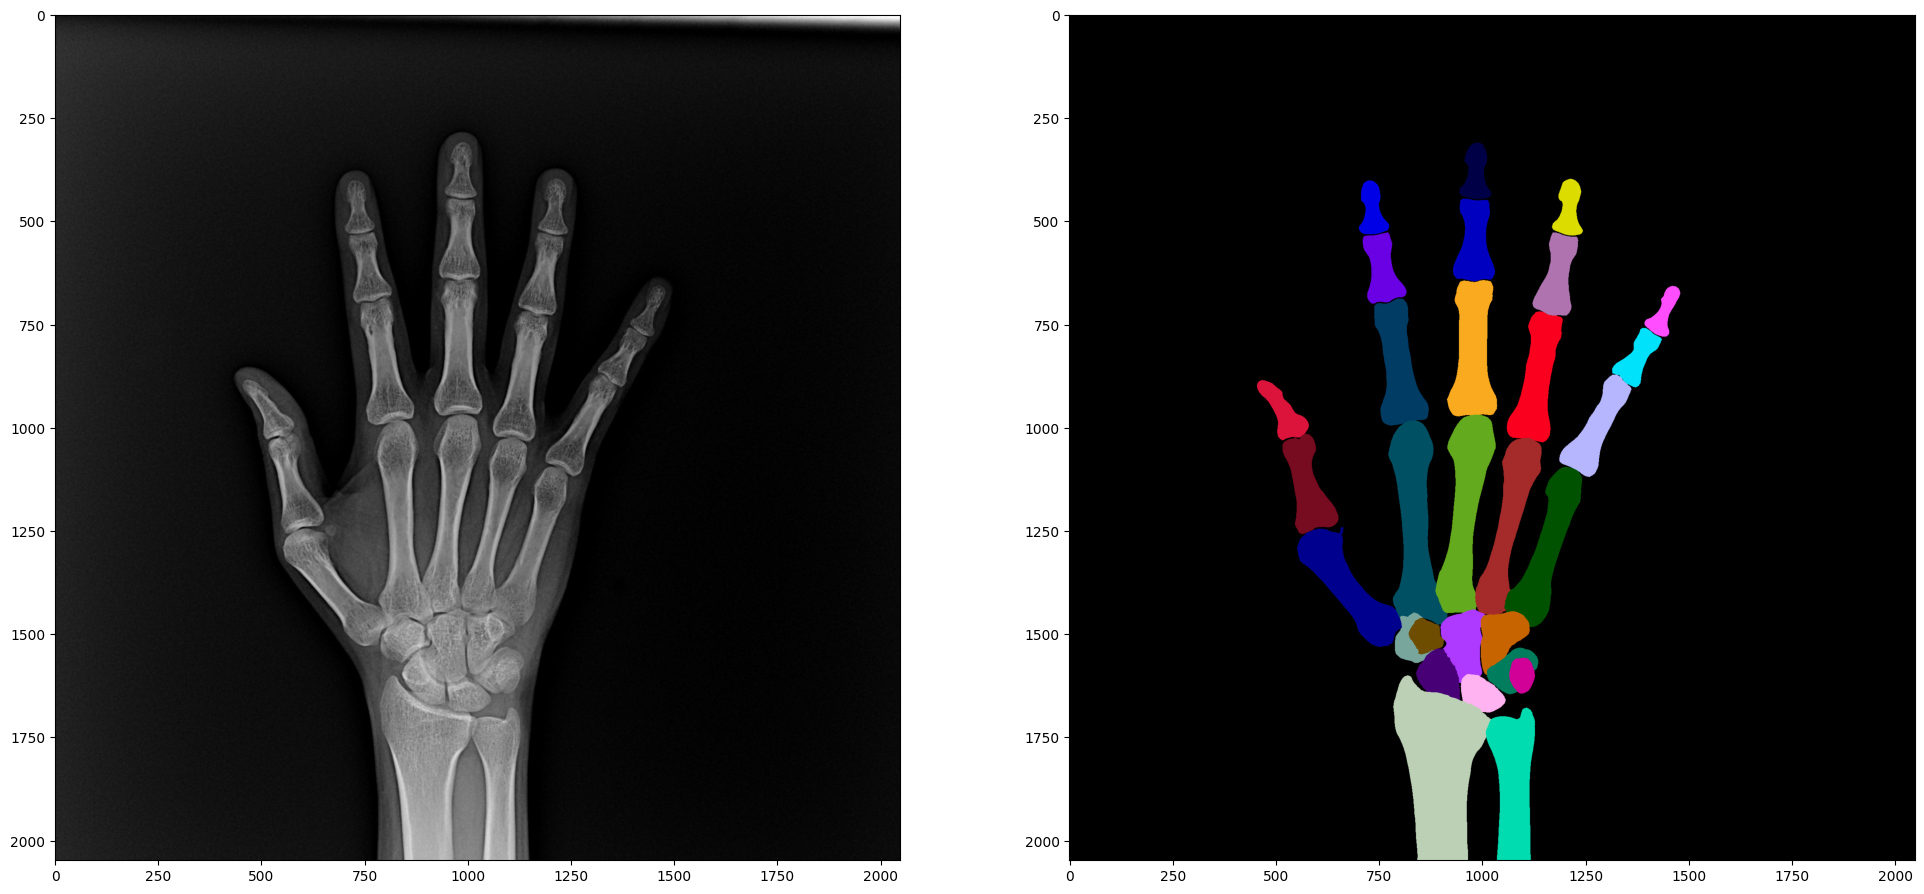

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

# To CSV

In [51]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

In [52]:
image_name = [os.path.basename(f) for f in filename]

In [53]:
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

In [54]:
df.head(30)

,image_name,class,rle
0,image1661319116107.png,finger-1,1814995 4 1817041 12 1819086 17 1821132 22 182...
1,image1661319116107.png,finger-2,2081340 4 2083386 12 2085432 15 2087478 19 208...
2,image1661319116107.png,finger-3,2544276 3 2546323 6 2548370 8 2550418 7 255241...
3,image1661319116107.png,finger-4,826068 10 828114 15 830160 19 832206 23 834253...
4,image1661319116107.png,finger-5,1082116 1 1084161 5 1086203 12 1088247 17 1090...
5,image1661319116107.png,finger-6,1411867 13 1413912 18 1415958 21 1418005 24 14...
6,image1661319116107.png,finger-7,2016059 16 2018103 24 2020148 29 2022193 33 20...
7,image1661319116107.png,finger-8,637914 8 639958 15 642004 19 644051 21 646097 ...
8,image1661319116107.png,finger-9,916410 14 918456 21 920502 27 922549 33 922602...
9,image1661319116107.png,finger-10,1319913 7 1321916 4 1321955 20 1323960 16 1324...


In [55]:
df.to_csv("output.csv", index=False)